<a href="https://colab.research.google.com/github/SrinathMLOps/MLPractise/blob/main/bias_variance_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bias-Variance Tradeoff and Overfitting/Underfitting Tutorial

## Learning Objectives
By the end of this tutorial, you will understand:
1. **Bias-Variance Tradeoff**: The fundamental tradeoff in machine learning
2. **Overfitting**: When models memorize training data but fail to generalize
3. **Underfitting**: When models are too simple to capture underlying patterns
4. **Model Complexity**: How to find the sweet spot between bias and variance

## Table of Contents
1. [Theory: Bias-Variance Decomposition](#theory)
2. [Overfitting vs Underfitting](#overfitting-underfitting)
3. [Practical Example 1: Polynomial Regression](#polynomial-regression)
4. [Practical Example 2: Classification with Decision Trees](#decision-trees)
5. [Validation Curves and Learning Curves](#validation-curves)
6. [Real-World Dataset Example](#real-world-example)
7. [Summary and Best Practices](#summary)


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, validation_curve, learning_curve, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.datasets import make_regression, load_iris
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


## 1. Theory: Bias-Variance Decomposition {#theory}

### What is Bias?
**Bias** is the error introduced by approximating a real-world problem with a simplified model.
- **High Bias**: Model makes strong assumptions about the data (underfitting)
- **Low Bias**: Model makes fewer assumptions, more flexible

### What is Variance?
**Variance** is the error introduced by the model's sensitivity to small fluctuations in the training set.
- **High Variance**: Model is very sensitive to training data (overfitting)
- **Low Variance**: Model is consistent across different training sets

### The Tradeoff
$$\text{Total Error} = \text{Bias}^2 + \text{Variance} + \text{Irreducible Error}$$

- **Simple models**: High bias, low variance
- **Complex models**: Low bias, high variance
- **Goal**: Find the optimal balance

### Visual Representation
Think of it like a dartboard:
- **High Bias, Low Variance**: Consistently hitting the same wrong spot
- **Low Bias, High Variance**: Hitting around the target but inconsistently
- **High Bias, High Variance**: Worst case - inconsistent and wrong
- **Low Bias, Low Variance**: Ideal - consistent and accurate


## 2. Overfitting vs Underfitting {#overfitting-underfitting}

### Underfitting (High Bias)
- Model is too simple to capture underlying patterns
- Poor performance on both training and test data
- Examples: Linear model for non-linear data, shallow decision tree
- **Symptoms**:
  - High training error
  - High test error
  - Training and test errors are close to each other

### Overfitting (High Variance)
- Model memorizes training data, including noise
- Excellent performance on training data, poor on test data
- Examples: Very deep decision tree, high-degree polynomial
- **Symptoms**:
  - Low training error
  - High test error
  - Large gap between training and test errors

### Sweet Spot (Good Fit)
- Model captures true underlying patterns without memorizing noise
- Good performance on both training and test data
- Optimal model complexity
- **Symptoms**:
  - Reasonably low training error
  - Low test error
  - Small gap between training and test errors


## 3. Practical Example 1: Polynomial Regression {#polynomial-regression}

Let's demonstrate bias-variance tradeoff using polynomial regression with different degrees.
We'll create a synthetic dataset with a known underlying function and add noise to simulate real-world data.


In [3]:
# Generate synthetic data with noise
def generate_data(n_samples=100, noise_level=0.3):
    X = np.linspace(0, 1, n_samples).reshape(-1, 1)
    # True function: sine wave with some polynomial component
    y_true = 1.5 * X.ravel() + np.sin(2 * np.pi * X.ravel()) + 0.5 * X.ravel()**2
    # Add noise
    y_noisy = y_true + np.random.normal(0, noise_level, n_samples)
    return X, y_noisy, y_true

# Generate training and test data
X_train, y_train, y_true_train = generate_data(50, 0.2)
X_test, y_test, y_true_test = generate_data(50, 0.2)

# Create fine-grained X for smooth plotting
X_plot = np.linspace(0, 1, 200).reshape(-1, 1)
y_plot_true = 1.5 * X_plot.ravel() + np.sin(2 * np.pi * X_plot.ravel()) + 0.5 * X_plot.ravel()**2

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print("True function: f(x) = 1.5x + sin(2πx) + 0.5x²")


Training set size: 50
Test set size: 50
True function: f(x) = 1.5x + sin(2πx) + 0.5x²


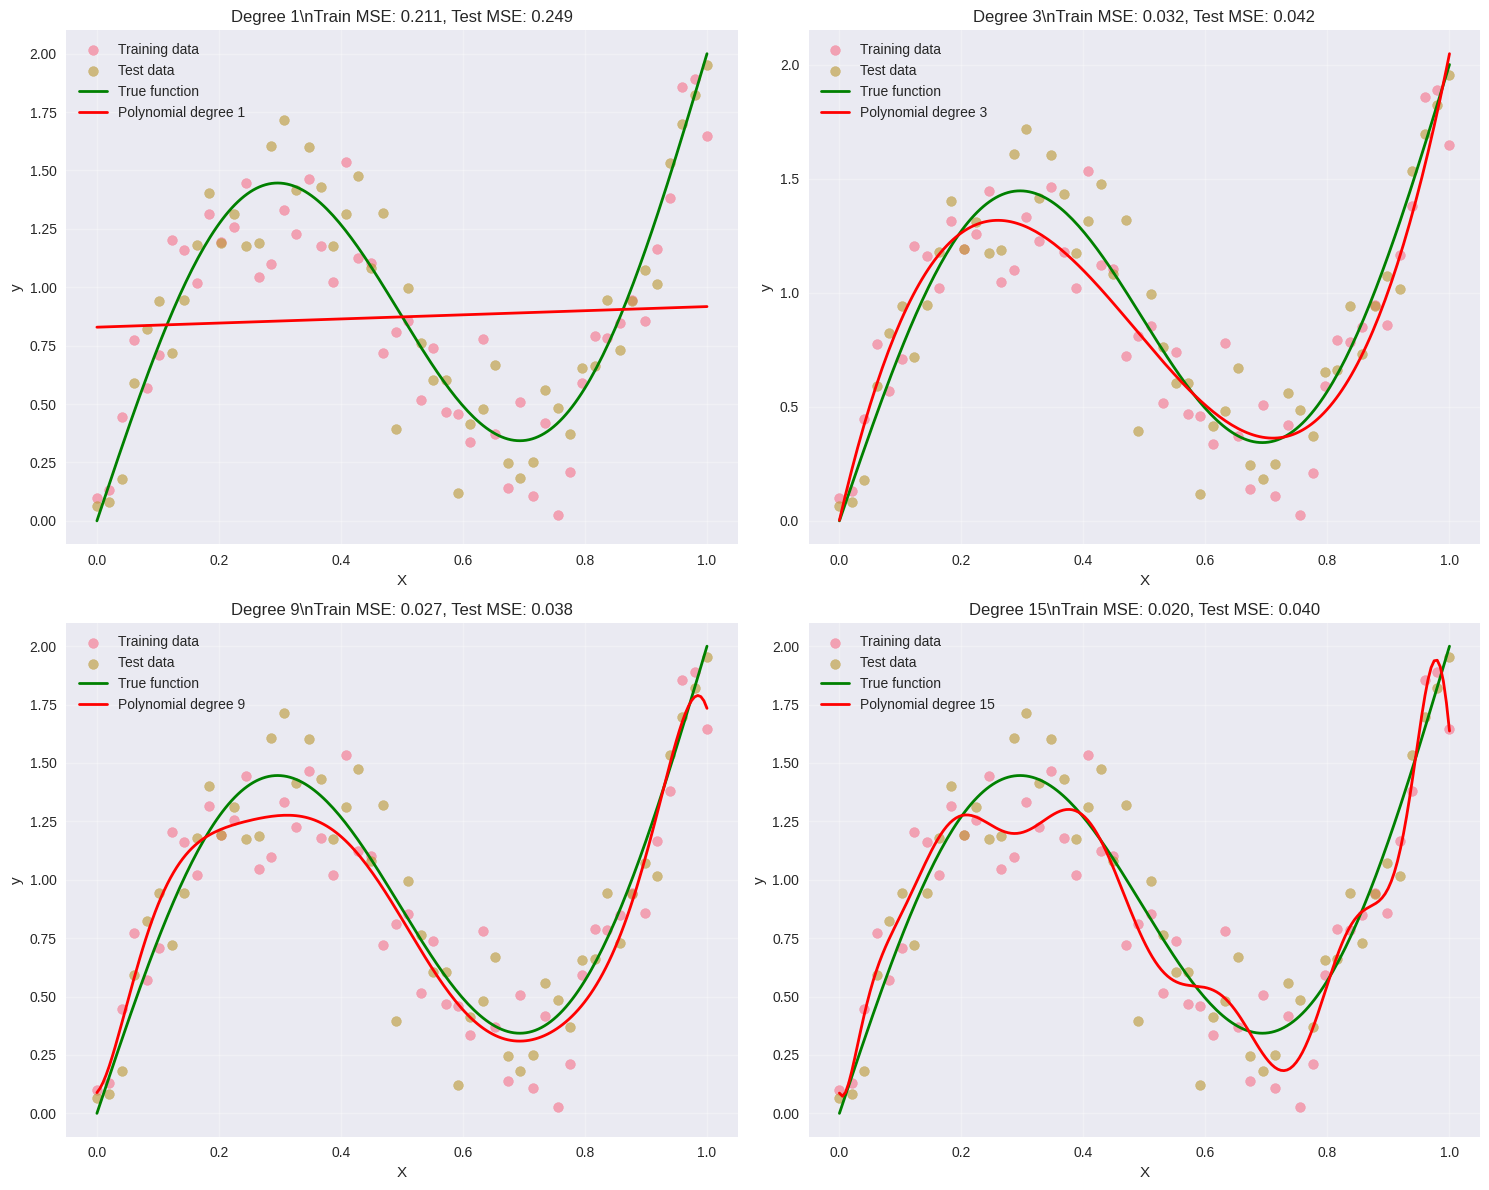

\nError Summary:
Degree  1: Train MSE = 0.2114, Test MSE = 0.2486
Degree  3: Train MSE = 0.0323, Test MSE = 0.0416
Degree  9: Train MSE = 0.0269, Test MSE = 0.0379
Degree 15: Train MSE = 0.0201, Test MSE = 0.0404


In [4]:
# Train polynomial models with different degrees
degrees = [1, 3, 9, 15]
models = {}
train_errors = []
test_errors = []

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, degree in enumerate(degrees):
    # Create polynomial features
    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(X_train)
    X_test_poly = poly_features.transform(X_test)
    X_plot_poly = poly_features.transform(X_plot)

    # Train model
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    models[degree] = (poly_features, model)

    # Make predictions
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)
    y_plot_pred = model.predict(X_plot_poly)

    # Calculate errors
    train_error = mean_squared_error(y_train, y_train_pred)
    test_error = mean_squared_error(y_test, y_test_pred)
    train_errors.append(train_error)
    test_errors.append(test_error)

    # Plot results
    axes[i].scatter(X_train, y_train, alpha=0.6, label='Training data', s=50)
    axes[i].scatter(X_test, y_test, alpha=0.6, label='Test data', s=50)
    axes[i].plot(X_plot, y_plot_true, 'g-', label='True function', linewidth=2)
    axes[i].plot(X_plot, y_plot_pred, 'r-', label=f'Polynomial degree {degree}', linewidth=2)
    axes[i].set_title(f'Degree {degree}\\nTrain MSE: {train_error:.3f}, Test MSE: {test_error:.3f}')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    axes[i].set_xlabel('X')
    axes[i].set_ylabel('y')

plt.tight_layout()
plt.show()

# Print error summary
print("\\nError Summary:")
for i, degree in enumerate(degrees):
    print(f"Degree {degree:2d}: Train MSE = {train_errors[i]:.4f}, Test MSE = {test_errors[i]:.4f}")


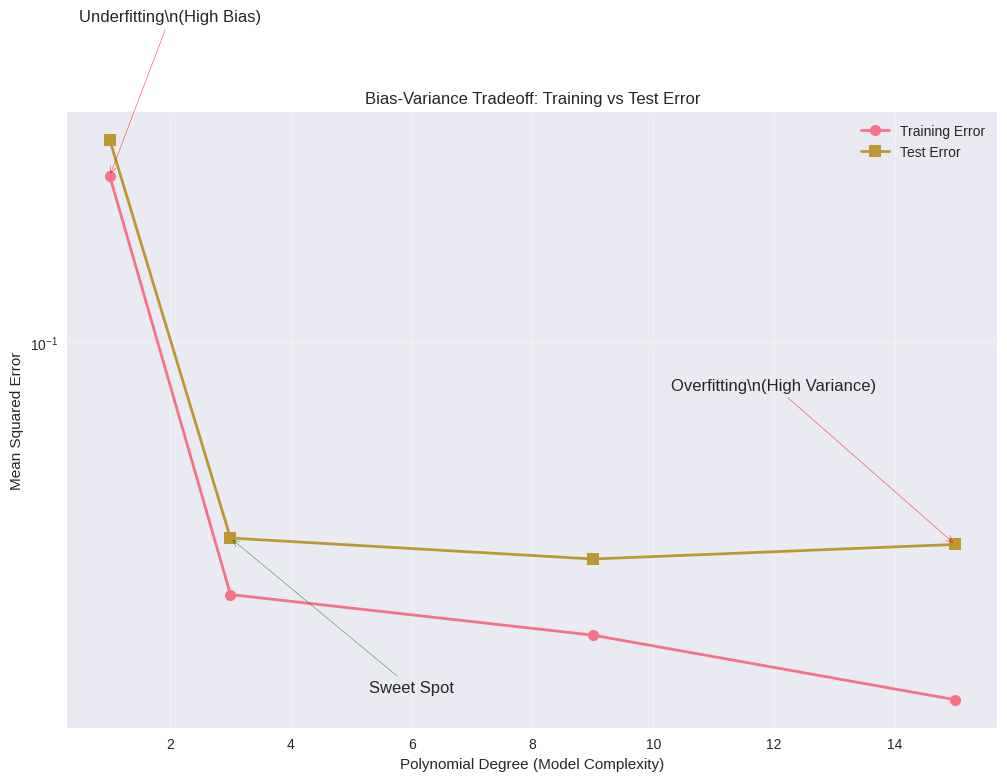

In [5]:
# Plot the bias-variance tradeoff
plt.figure(figsize=(12, 8))
plt.plot(degrees, train_errors, 'o-', label='Training Error', linewidth=2, markersize=8)
plt.plot(degrees, test_errors, 's-', label='Test Error', linewidth=2, markersize=8)
plt.xlabel('Polynomial Degree (Model Complexity)')
plt.ylabel('Mean Squared Error')
plt.title('Bias-Variance Tradeoff: Training vs Test Error')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Add annotations
plt.annotate('Underfitting\\n(High Bias)', xy=(1, train_errors[0]), xytext=(2, train_errors[0]*2),
            arrowprops=dict(arrowstyle='->', color='red'), fontsize=12, ha='center')
plt.annotate('Overfitting\\n(High Variance)', xy=(15, test_errors[3]), xytext=(12, test_errors[3]*2),
            arrowprops=dict(arrowstyle='->', color='red'), fontsize=12, ha='center')
plt.annotate('Sweet Spot', xy=(3, test_errors[1]), xytext=(6, test_errors[1]/2),
            arrowprops=dict(arrowstyle='->', color='green'), fontsize=12, ha='center')

plt.show()


### Analysis of Polynomial Regression Results

**Degree 1 (Linear)**:
- **Underfitting**: Too simple to capture the true non-linear relationship
- High bias, low variance
- Poor performance on both training and test data

**Degree 3**:
- **Good balance**: Captures main patterns without too much noise
- Reasonable bias and variance
- Good performance on both training and test data

**Degree 9**:
- **Starting to overfit**: Begins to memorize training data
- Lower bias, higher variance
- Better training performance, worse test performance

**Degree 15**:
- **Severe overfitting**: Completely memorizes training data
- Very low bias, very high variance
- Excellent training performance, terrible test performance

Notice how the **test error first decreases then increases** as model complexity grows - this is the classic bias-variance tradeoff curve!


## 4. Practical Example 2: Classification with Decision Trees {#decision-trees}

Let's explore overfitting in classification using decision trees with different depths.
Decision trees are particularly prone to overfitting as they can create very complex decision boundaries.


In [6]:
# Load the Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Dataset shape: {X.shape}")
print(f"Classes: {iris.target_names}")
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# Show feature names for context
print(f"Features: {iris.feature_names}")


Dataset shape: (150, 4)
Classes: ['setosa' 'versicolor' 'virginica']
Training set size: 105
Test set size: 45
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


Max Depth         1: Train Accuracy = 0.6667, Test Accuracy = 0.6667
Max Depth         2: Train Accuracy = 0.9714, Test Accuracy = 0.8889
Max Depth         3: Train Accuracy = 0.9810, Test Accuracy = 0.9778
Max Depth         5: Train Accuracy = 1.0000, Test Accuracy = 0.9333
Max Depth        10: Train Accuracy = 1.0000, Test Accuracy = 0.9333
Max Depth Unlimited: Train Accuracy = 1.0000, Test Accuracy = 0.9333


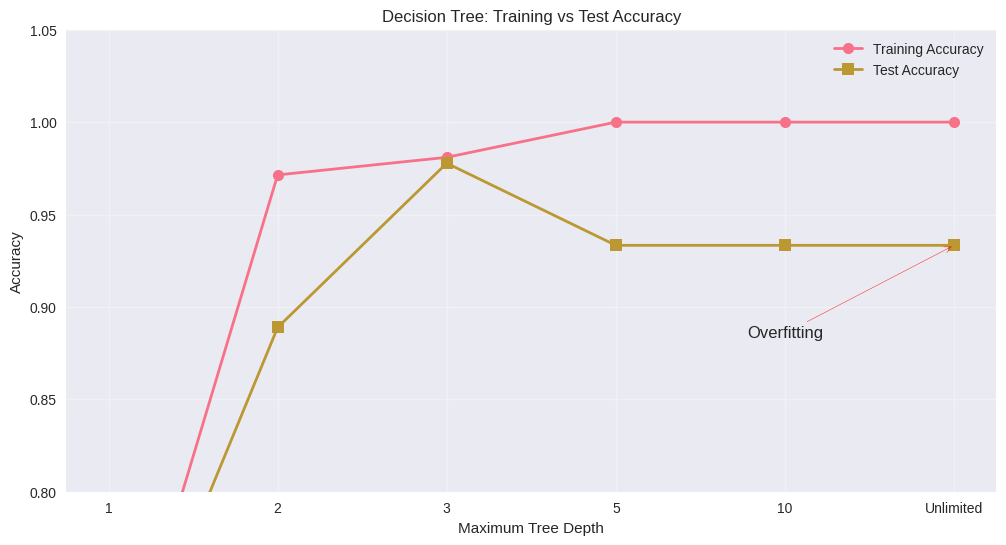

In [7]:
# Train decision trees with different max depths
max_depths = [1, 2, 3, 5, 10, None]  # None means no limit
train_accuracies = []
test_accuracies = []

for depth in max_depths:
    # Train decision tree
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf.fit(X_train, y_train)

    # Make predictions
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    # Calculate accuracies
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    depth_str = str(depth) if depth is not None else 'Unlimited'
    print(f"Max Depth {depth_str:>9}: Train Accuracy = {train_acc:.4f}, Test Accuracy = {test_acc:.4f}")

# Plot the results
depth_labels = [str(d) if d is not None else 'Unlimited' for d in max_depths]
x_pos = range(len(max_depths))

plt.figure(figsize=(12, 6))
plt.plot(x_pos, train_accuracies, 'o-', label='Training Accuracy', linewidth=2, markersize=8)
plt.plot(x_pos, test_accuracies, 's-', label='Test Accuracy', linewidth=2, markersize=8)
plt.xlabel('Maximum Tree Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree: Training vs Test Accuracy')
plt.xticks(x_pos, depth_labels)
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0.8, 1.05)

# Add annotations
plt.annotate('Underfitting', xy=(0, train_accuracies[0]), xytext=(1, train_accuracies[0]-0.05),
            arrowprops=dict(arrowstyle='->', color='red'), fontsize=12, ha='center')
plt.annotate('Overfitting', xy=(5, test_accuracies[5]), xytext=(4, test_accuracies[5]-0.05),
            arrowprops=dict(arrowstyle='->', color='red'), fontsize=12, ha='center')

plt.show()


## 5. Validation Curves and Learning Curves {#validation-curves}

### Validation Curves
Show how model performance changes with a hyperparameter (e.g., model complexity).

### Learning Curves
Show how model performance changes with training set size.

These are essential tools for diagnosing bias-variance problems!


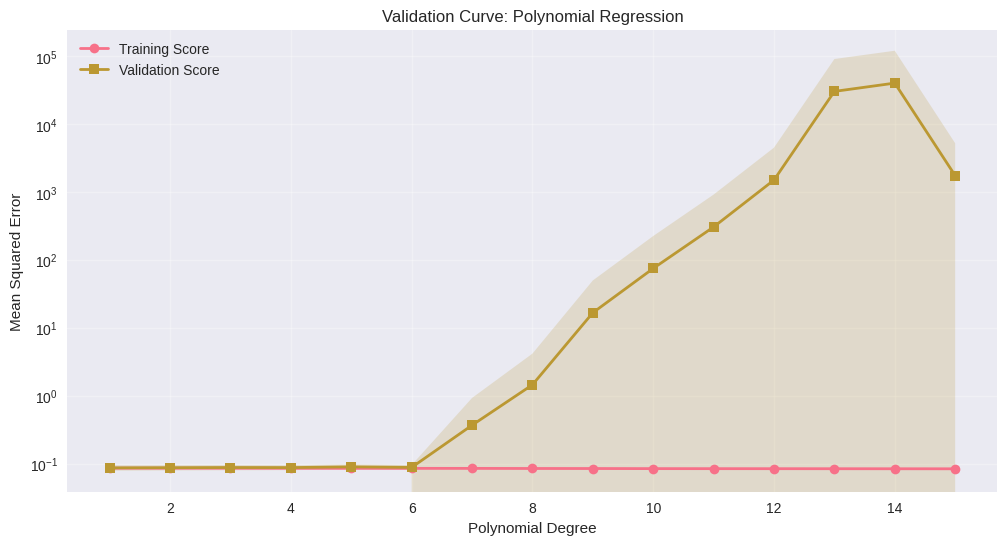

Optimal polynomial degree: 1


In [8]:
# Generate a more complex dataset for better demonstration
X_complex, y_complex = make_regression(n_samples=1000, n_features=1, noise=0.3, random_state=42)
X_train_complex, X_test_complex, y_train_complex, y_test_complex = train_test_split(
    X_complex, y_complex, test_size=0.3, random_state=42
)

# Create validation curve for polynomial regression
degrees = range(1, 16)
train_scores, test_scores = validation_curve(
    Pipeline([('poly', PolynomialFeatures()), ('linear', LinearRegression())]),
    X_train_complex, y_train_complex,
    param_name='poly__degree',
    param_range=degrees,
    cv=5, scoring='neg_mean_squared_error'
)

# Convert to positive MSE
train_scores = -train_scores
test_scores = -test_scores

# Calculate mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot validation curve
plt.figure(figsize=(12, 6))
plt.plot(degrees, train_mean, 'o-', label='Training Score', linewidth=2)
plt.fill_between(degrees, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.plot(degrees, test_mean, 's-', label='Validation Score', linewidth=2)
plt.fill_between(degrees, test_mean - test_std, test_mean + test_std, alpha=0.2)

plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.title('Validation Curve: Polynomial Regression')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

# Find optimal degree
optimal_degree = degrees[np.argmin(test_mean)]
print(f"Optimal polynomial degree: {optimal_degree}")


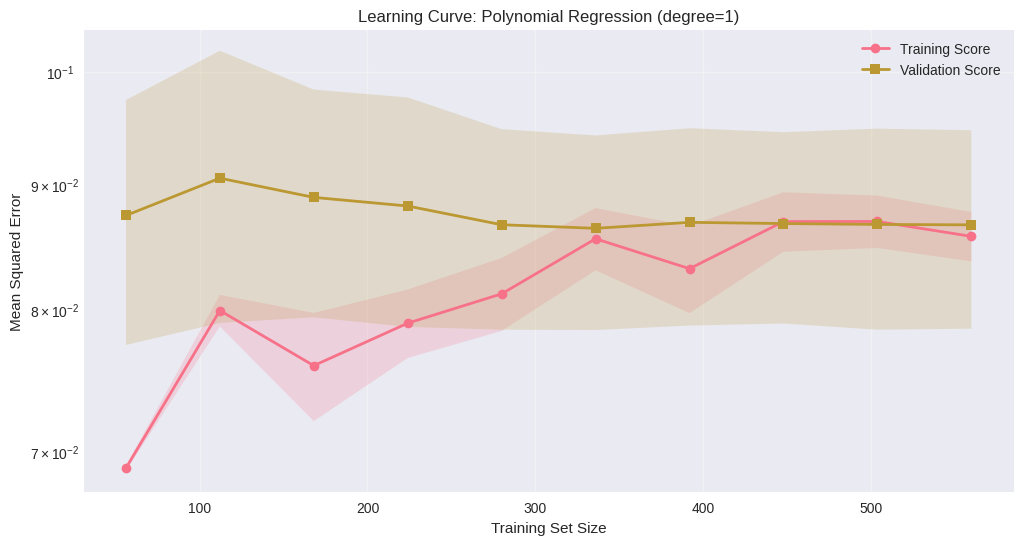

Learning Curve Analysis:
- If training and validation scores converge at a high error → High Bias (Underfitting)
- If there's a large gap between training and validation scores → High Variance (Overfitting)
- If both curves converge at a low error → Good fit!


In [9]:
# Create learning curve
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes_abs, train_scores, test_scores = learning_curve(
    Pipeline([('poly', PolynomialFeatures(degree=optimal_degree)), ('linear', LinearRegression())]),
    X_train_complex, y_train_complex,
    train_sizes=train_sizes,
    cv=5, scoring='neg_mean_squared_error'
)

# Convert to positive MSE
train_scores = -train_scores
test_scores = -test_scores

# Calculate mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(12, 6))
plt.plot(train_sizes_abs, train_mean, 'o-', label='Training Score', linewidth=2)
plt.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.plot(train_sizes_abs, test_mean, 's-', label='Validation Score', linewidth=2)
plt.fill_between(train_sizes_abs, test_mean - test_std, test_mean + test_std, alpha=0.2)

plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.title(f'Learning Curve: Polynomial Regression (degree={optimal_degree})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

print("Learning Curve Analysis:")
print("- If training and validation scores converge at a high error → High Bias (Underfitting)")
print("- If there's a large gap between training and validation scores → High Variance (Overfitting)")
print("- If both curves converge at a low error → Good fit!")


## 6. Real-World Example: Regularization to Combat Overfitting {#real-world-example}

Let's use a synthetic dataset to demonstrate how regularization can help with overfitting.
We'll show how Ridge regression can control the bias-variance tradeoff.


In [10]:
# Create a synthetic dataset with multiple features
X_housing, y_housing = make_regression(
    n_samples=500, n_features=13, noise=0.1, random_state=42
)

# Add some feature names for better understanding
feature_names = [f'feature_{i+1}' for i in range(13)]
housing_df = pd.DataFrame(X_housing, columns=feature_names)
housing_df['target'] = y_housing

print("Dataset Information:")
print(f"Shape: {housing_df.shape}")
print(f"Features: {housing_df.columns.tolist()[:-1]}")
print("\\nFirst few rows:")
print(housing_df.head())


Dataset Information:
Shape: (500, 14)
Features: ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13']
\nFirst few rows:
   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0   0.446982  -2.153731  -0.638586   1.223856   0.239858  -0.592241   
1  -0.230401  -0.758495  -0.924233   0.260281  -1.846188  -0.957151   
2   0.281009  -1.315816  -2.132596   0.307613   3.243093   1.352203   
3  -0.389924  -1.751829   0.158053   0.313184  -0.945746   0.455904   
4  -1.571152   1.006730   1.081514  -0.350778  -0.070220   0.715493   

   feature_7  feature_8  feature_9  feature_10  feature_11  feature_12  \
0   0.486310   1.653310   0.337956    0.000756    0.623087    0.975713   
1  -0.929511   0.890198  -0.963759   -0.048652    1.035249    0.343788   
2   2.307916   1.012637  -0.524567    0.039447   -0.158154    0.424067   
3   0.608246  -0.096624  -0.606503   

In [11]:
# Split the data and standardize features
X = housing_df.drop('target', axis=1)
y = housing_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Compare different degrees of polynomial features with and without regularization
degrees = [1, 2, 3, 4, 5]
alpha_values = [0, 0.1, 1, 10, 100]  # 0 means no regularization (Linear Regression)

results = []

for degree in degrees:
    for alpha in alpha_values:
        # Create polynomial features
        poly = PolynomialFeatures(degree=degree)
        X_train_poly = poly.fit_transform(X_train_scaled)
        X_test_poly = poly.transform(X_test_scaled)

        # Train model
        if alpha == 0:
            model = LinearRegression()
        else:
            model = Ridge(alpha=alpha)

        model.fit(X_train_poly, y_train)

        # Make predictions
        y_train_pred = model.predict(X_train_poly)
        y_test_pred = model.predict(X_test_poly)

        # Calculate errors
        train_mse = mean_squared_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)

        results.append({
            'degree': degree,
            'alpha': alpha,
            'train_mse': train_mse,
            'test_mse': test_mse,
            'overfitting': test_mse - train_mse
        })

results_df = pd.DataFrame(results)
print("Sample results:")
print(results_df.head(10))


Sample results:
   degree  alpha    train_mse     test_mse  overfitting
0       1    0.0     0.010439     0.012647     0.002208
1       1    0.1     0.014671     0.017817     0.003146
2       1    1.0     0.431010     0.488316     0.057306
3       1   10.0    39.646986    44.401401     4.754415
4       1  100.0  2386.252480  2632.321659   246.069179
5       2    0.0     0.007793     0.016686     0.008893
6       2    0.1     0.014326     0.031266     0.016940
7       2    1.0     0.652134     1.399477     0.747343
8       2   10.0    56.647942   116.541441    59.893499
9       2  100.0  2484.492332  4188.108190  1703.615858


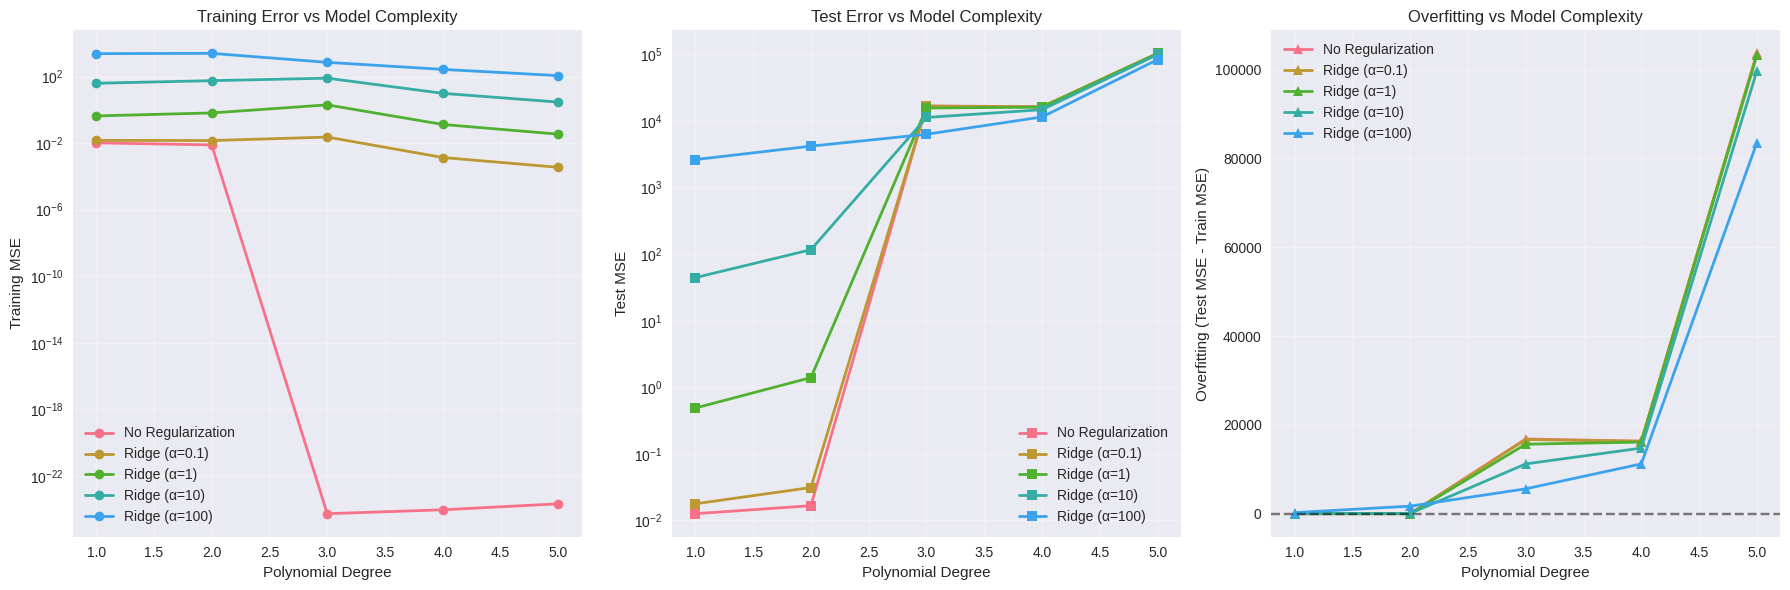

In [12]:
# Visualize the effect of regularization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Training MSE vs Degree for different regularization strengths
for alpha in alpha_values:
    subset = results_df[results_df['alpha'] == alpha]
    label = 'No Regularization' if alpha == 0 else f'Ridge (α={alpha})'
    axes[0].plot(subset['degree'], subset['train_mse'], 'o-', label=label, linewidth=2)

axes[0].set_xlabel('Polynomial Degree')
axes[0].set_ylabel('Training MSE')
axes[0].set_title('Training Error vs Model Complexity')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')

# Plot 2: Test MSE vs Degree for different regularization strengths
for alpha in alpha_values:
    subset = results_df[results_df['alpha'] == alpha]
    label = 'No Regularization' if alpha == 0 else f'Ridge (α={alpha})'
    axes[1].plot(subset['degree'], subset['test_mse'], 's-', label=label, linewidth=2)

axes[1].set_xlabel('Polynomial Degree')
axes[1].set_ylabel('Test MSE')
axes[1].set_title('Test Error vs Model Complexity')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_yscale('log')

# Plot 3: Overfitting (Test - Train) vs Degree
for alpha in alpha_values:
    subset = results_df[results_df['alpha'] == alpha]
    label = 'No Regularization' if alpha == 0 else f'Ridge (α={alpha})'
    axes[2].plot(subset['degree'], subset['overfitting'], '^-', label=label, linewidth=2)

axes[2].set_xlabel('Polynomial Degree')
axes[2].set_ylabel('Overfitting (Test MSE - Train MSE)')
axes[2].set_title('Overfitting vs Model Complexity')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


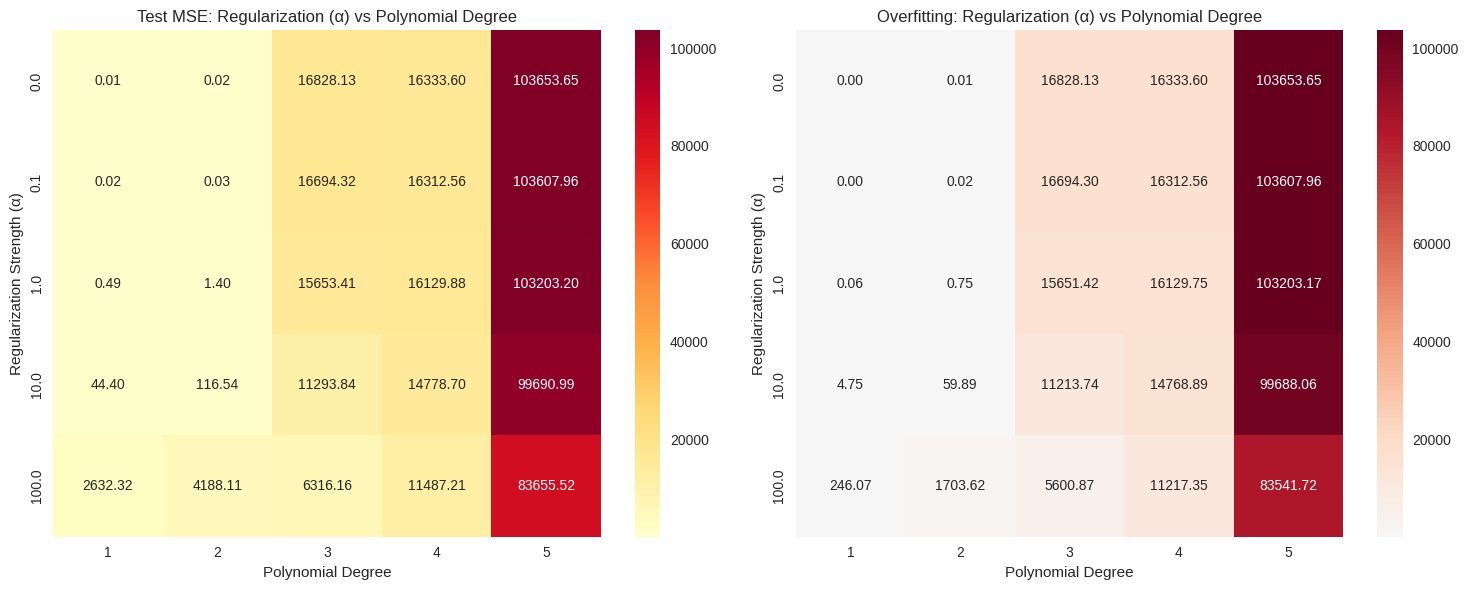

\nBest combination:
Polynomial Degree: 1.0
Regularization (α): 0.0
Test MSE: 0.0126
Overfitting: 0.0022
\nKey Insights:
• Higher regularization (α) reduces overfitting but may increase bias
• Lower regularization allows more flexibility but risks overfitting
• The optimal combination balances both concerns


In [13]:
# Create heatmaps to show the best combination
pivot_test = results_df.pivot(index='alpha', columns='degree', values='test_mse')
pivot_overfitting = results_df.pivot(index='alpha', columns='degree', values='overfitting')

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Test MSE heatmap
sns.heatmap(pivot_test, annot=True, fmt='.2f', cmap='YlOrRd', ax=axes[0])
axes[0].set_title('Test MSE: Regularization (α) vs Polynomial Degree')
axes[0].set_xlabel('Polynomial Degree')
axes[0].set_ylabel('Regularization Strength (α)')

# Overfitting heatmap
sns.heatmap(pivot_overfitting, annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=axes[1])
axes[1].set_title('Overfitting: Regularization (α) vs Polynomial Degree')
axes[1].set_xlabel('Polynomial Degree')
axes[1].set_ylabel('Regularization Strength (α)')

plt.tight_layout()
plt.show()

# Find the best combination
best_result = results_df.loc[results_df['test_mse'].idxmin()]
print(f"\\nBest combination:")
print(f"Polynomial Degree: {best_result['degree']}")
print(f"Regularization (α): {best_result['alpha']}")
print(f"Test MSE: {best_result['test_mse']:.4f}")
print(f"Overfitting: {best_result['overfitting']:.4f}")

print("\\nKey Insights:")
print("• Higher regularization (α) reduces overfitting but may increase bias")
print("• Lower regularization allows more flexibility but risks overfitting")
print("• The optimal combination balances both concerns")


## 7. Ensemble Methods: Balancing Bias and Variance {#ensemble-methods}

Ensemble methods can provide an excellent balance between bias and variance by combining multiple models.


In [14]:
# Final demonstration: Ensemble methods for bias-variance tradeoff
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

# Create models with different bias-variance characteristics
models = {
    'High Bias\\n(Shallow Tree)': DecisionTreeRegressor(max_depth=2, random_state=42),
    'High Variance\\n(Deep Tree)': DecisionTreeRegressor(max_depth=20, random_state=42),
    'Balanced\\n(Random Forest)': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    'Bagging\\n(Reduced Variance)': BaggingRegressor(DecisionTreeRegressor(max_depth=20),
                                                   n_estimators=100, random_state=42)
}

# Test on the housing dataset
results = []
for name, model in models.items():
    # Use cross-validation for more robust results
    cv_scores = cross_val_score(model, X_train_scaled, y_train,
                               cv=5, scoring='neg_mean_squared_error')

    # Fit on full training set and test
    model.fit(X_train_scaled, y_train)
    train_pred = model.predict(X_train_scaled)
    test_pred = model.predict(X_test_scaled)

    train_mse = mean_squared_error(y_train, train_pred)
    test_mse = mean_squared_error(y_test, test_pred)
    cv_mse = -cv_scores.mean()
    cv_std = cv_scores.std()

    results.append({
        'Model': name,
        'Train MSE': train_mse,
        'Test MSE': test_mse,
        'CV MSE': cv_mse,
        'CV Std': cv_std,
        'Overfitting': test_mse - train_mse
    })

results_df = pd.DataFrame(results)
print("Model Comparison:")
print(results_df.round(4))


Model Comparison:
                         Model   Train MSE    Test MSE      CV MSE     CV Std  \
0    High Bias\n(Shallow Tree)  26156.6177  41416.3688  34153.9340  5827.4048   
1   High Variance\n(Deep Tree)      0.0000  31176.7763  33165.7039  3904.4034   
2    Balanced\n(Random Forest)   1852.7636  15364.7437  14112.5728  3235.2478   
3  Bagging\n(Reduced Variance)   1821.6646  15277.4821  14006.4419  3274.5128   

   Overfitting  
0   15259.7511  
1   31176.7763  
2   13511.9801  
3   13455.8175  


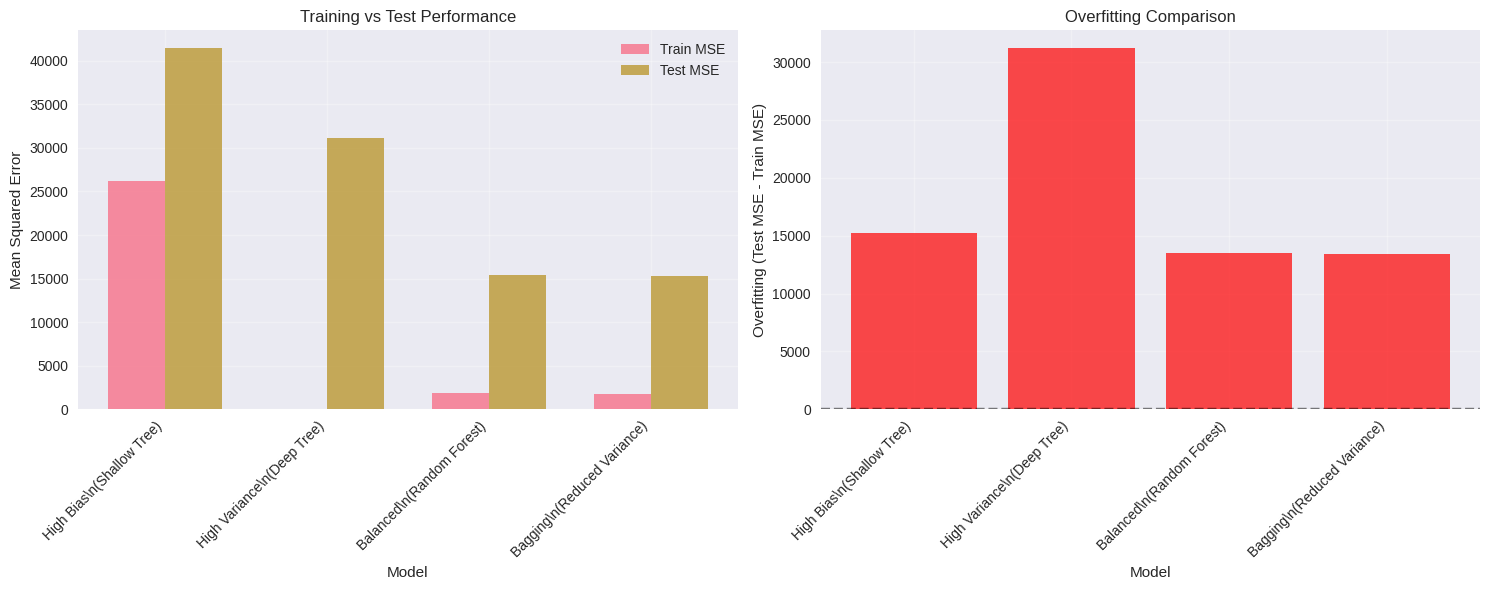

\nEnsemble Method Analysis:
• Shallow Tree: High bias, low variance (underfitting)
• Deep Tree: Low bias, high variance (overfitting)
• Random Forest: Good balance by averaging multiple trees
• Bagging: Reduces variance by averaging predictions


In [15]:
# Visualize the results
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: MSE comparison
x = range(len(results_df))
width = 0.35
axes[0].bar([i - width/2 for i in x], results_df['Train MSE'], width, label='Train MSE', alpha=0.8)
axes[0].bar([i + width/2 for i in x], results_df['Test MSE'], width, label='Test MSE', alpha=0.8)
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Mean Squared Error')
axes[0].set_title('Training vs Test Performance')
axes[0].set_xticks(x)
axes[0].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Overfitting comparison
colors = ['red' if x > 0 else 'green' for x in results_df['Overfitting']]
axes[1].bar(x, results_df['Overfitting'], color=colors, alpha=0.7)
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Overfitting (Test MSE - Train MSE)')
axes[1].set_title('Overfitting Comparison')
axes[1].set_xticks(x)
axes[1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\\nEnsemble Method Analysis:")
print("• Shallow Tree: High bias, low variance (underfitting)")
print("• Deep Tree: Low bias, high variance (overfitting)")
print("• Random Forest: Good balance by averaging multiple trees")
print("• Bagging: Reduces variance by averaging predictions")


## 8. Summary and Best Practices {#summary}

### Key Takeaways

1. **Bias-Variance Tradeoff**:
   - **Simple models**: High bias, low variance (underfitting)
   - **Complex models**: Low bias, high variance (overfitting)
   - **Goal**: Find the optimal balance for best generalization

2. **Detecting Problems**:
   - **Underfitting**: Poor performance on both training and test data
   - **Overfitting**: Large gap between training and test performance
   - **Good fit**: Good performance on both with small gap

3. **Diagnostic Tools**:
   - **Validation curves**: Tune hyperparameters
   - **Learning curves**: Understand data requirements
   - **Cross-validation**: Robust performance estimates

### Best Practices

#### To Combat Underfitting (High Bias):
- Increase model complexity
- Add more features or polynomial features
- Reduce regularization
- Use more sophisticated algorithms

#### To Combat Overfitting (High Variance):
- Collect more training data
- Reduce model complexity  
- Add regularization (Ridge, Lasso, Elastic Net)
- Use ensemble methods
- Apply early stopping
- Use dropout (for neural networks)

#### General Guidelines:
- Always use cross-validation for model selection
- Plot learning curves to understand data needs
- Start simple, then increase complexity gradually
- Regularization is often your friend
- Ensemble methods can provide excellent bias-variance balance

### The Golden Rule
**"All models are wrong, but some are useful"** - George Box

The goal is not to find the perfect model, but to find a model that generalizes well to new, unseen data while being interpretable and practical for your specific problem.


## 🎯 Interactive Exercise

Try experimenting with the code above! Here are some suggestions:

1. **Change the noise level** in the data generation function and see how it affects overfitting
2. **Try different polynomial degrees** beyond what we tested
3. **Experiment with different regularization strengths** in Ridge regression
4. **Use different algorithms** like Support Vector Machines or Neural Networks
5. **Apply the concepts to a real dataset** you're working with

## 📚 Further Reading

- **Books**:
  - "The Elements of Statistical Learning" by Hastie, Tibshirani, and Friedman
  - "Pattern Recognition and Machine Learning" by Christopher Bishop
  
- **Online Resources**:
  - Scikit-learn documentation on model evaluation
  - Andrew Ng's Machine Learning Course (Coursera)
  - "Hands-On Machine Learning" by Aurélien Géron

---

**Congratulations!** You now have a solid understanding of the bias-variance tradeoff and how to diagnose and address overfitting and underfitting in machine learning models. These concepts are fundamental to becoming a successful machine learning practitioner!
